<a href="https://www.kaggle.com/code/aisuko/implement-gpt2-124m-and-load-hf-gpt2?scriptVersionId=220048348" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Load GPT2 for weights for same model family and class.

# Load Huggingface GPT2

In [1]:
from transformers import GPT2LMHeadModel

model_hf=GPT2LMHeadModel.from_pretrained('gpt2') # 124M
sd_hf=model_hf.state_dict()

for k,v in sd_hf.items():
    print(k,v.shape)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [2]:
sd_hf['transformer.wpe.weight'].view(-1)[:20]

tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
        -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
        -0.0063, -0.0461,  0.0267, -0.2042])

## Visualization dimensions

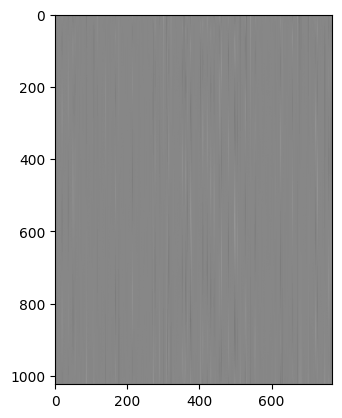

In [3]:
import matplotlib.pyplot as plt

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

### The chart below illustrates that the model did not train well

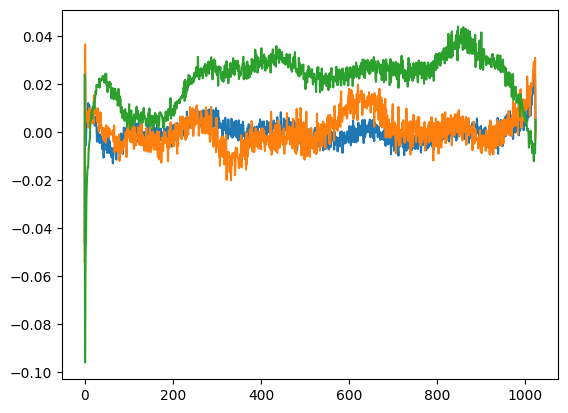

In [4]:
plt.plot(sd_hf['transformer.wpe.weight'][:, 150])
plt.plot(sd_hf['transformer.wpe.weight'][:, 200])
plt.plot(sd_hf['transformer.wpe.weight'][:, 250])

## Inference with Huggingface pipeline and GPT2

In [5]:
from transformers import pipeline, set_seed

generator=pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hello, I\'m a language model, so you can\'t define something in any other language. Let me introduce another topic:\n\nThe name "'},
 {'generated_text': "Hello, I'm a language model, you know.\n\nThat's right… I have a lot of friends who don't know what I do"},
 {'generated_text': "Hello, I'm a language model, not a formal one. I'm more interested in languages than formal models and I'm going to use the formal"},
 {'generated_text': "Hello, I'm a language model, but I'm not trying to make humans and monkeys, I just want people to feel comfortable. And when you"},
 {'generated_text': "Hello, I'm a language model, the code is what you're looking for\n\nLet me illustrate this:\n\nThis is the main main"}]

## The shape of the input and final output is the same

In [6]:
# 768 channel with 50257 features
print(sd_hf["lm_head.weight"].shape)
print(sd_hf["transformer.wte.weight"].shape)

torch.Size([50257, 768])
torch.Size([50257, 768])


In [7]:
(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()

tensor(True)

## Check the data pointer of the tensor

In [8]:
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

136989505237056
136989505237056


# Implement GPT2 from scratch and load the GPT2 weights

In [9]:
import math
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F


class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn=nn.Linear(config.n_embd, 3*config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT=1
        # regularization
        self.n_head=config.n_head
        self.n_embd=config.n_embd
        # not really a `bias`, more of a mask
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size,)).view(1, 1, config.block_size, config.block_size)
        )

    def forward(self, x):
        B,T,C=x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calcualte query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv=self.c_attn(x)
        q,k,v=qkv.split(self.n_embd, dim=2)
        k=k.view(B,T,self.n_head, C//self.n_head).transpose(1,2) # (B, nh, T, hs)
        q=q.view(B,T,self.n_head, C//self.n_head).transpose(1,2) # (B, nh, T, hs)
        v=v.view(B,T,self.n_head, C//self.n_head).transpose(1,2) # (B, nh, T, hs)

        
        # attention (materializes the large (T,T) matrix for all the queries and keys)
        # att=(q@k.transpose(-2,-1)) * (1.0 / math.sqrt(k.size(-1)))
        # att=att.masked_fill(self.bias[:,:,:T,:T] ==0, float('-inf'))
        # att=F.softmax(att,dim=-1)
        # y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # switch to flash attention
        
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y=self.c_proj(y)
        return y


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc=nn.Linear(config.n_embd, 4*config.n_embd)
        self.gelu=nn.GELU(approximate='tanh')
        self.c_proj=nn.Linear(4*config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT=1
    def forward(self, x):
        x=self.c_fc(x)
        x=self.gelu(x)
        x=self.c_proj(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1=nn.LayerNorm(config.n_embd)
        self.attn=CausalSelfAttention(config)
        self.ln_2=nn.LayerNorm(config.n_embd)
        self.mlp=MLP(config)

    def forward(self,x):
        x=x+self.attn(self.ln_1(x))
        x=x+self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int=1024 # max sequence length
    vocab_size: int=50257 # number of tokens: 50,000 BPE merges + 256 bytes toknes + 1<|endoftext|> token
    n_layer: int =12
    n_head: int=12
    n_embd: int=768

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config=config
        self.transformer=nn.ModuleDict(
            dict(
                wte=nn.Embedding(config.vocab_size, config.n_embd), # output embedding
                wpe=nn.Embedding(config.block_size, config.n_embd), # positional encoding
                h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # masked multi-head attention(GPT2 version)
                ln_f=nn.LayerNorm(config.n_embd), # linear layer
                )
        )
        self.lm_head=nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # fix the bug
        # weight sharing scheme
        self.transformer.wte.weight=self.lm_head.weight

        # model initialization: std=0.02, residual init
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std=0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std*=(2*self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    # Implementing the forward pass to get logits
    def forward(self, idx, targets=None):
        # idx is of shape (B,T) batch dimension and time dimension
        B,T =idx.size()
        # T should less than the maximum sequence length
        assert T<=self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # Generate a 1-dimensional tensor using torch.arange(start, end ) to forward the token and position embeddings.
        pos=torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb=self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb=self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x=tok_emb+pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x=block(x)
        # forward the final layernorm and the classifer
        x=self.transformer.ln_f(x)
        logits=self.lm_head(x) # (B,T, vocab-size)

        loss=None
        if targets is not None:
            loss=F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Load pretrained GPT-2 model weights from Huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args={
            "gpt2": dict(n_layer=12, n_head=12, n_embd=768), # 124M params
            "gpt2-medium": dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            "gpt2-large": dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            "gpt2-xl": dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size']=50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints

        config=GPTConfig(**config_args)
        model=GPT(config)
        sd=model.state_dict()
        sd_keys=sd.keys()
        sd_keys=[k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask /buffer, not a param

        # init a huggingface/transformers model
        model_hf=GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf=model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf=sd_hf.keys()

        sd_keys_hf=[k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf=[k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed=['attn.c_attn.weight', 'attn.c_proj.weight','mlp.c_fc.weight','mlp.c_proj.weight'] # hardcode layers from tensorflow
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear this means that we
        # have to transpose these weights when we import them
        assert len(sd_keys_hf) ==len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} !={len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1]==sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape==sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model

    # add weight decaym only for 2D params, and add fused AdamW
    def configure_optimizers(self, weight_decay, learning_rate, device):
        # start with all of the candidate parameters
        param_dict={pn: p for pn, p in self.named_parameters()}
        param_dict={pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't
        decay_params=[p for n,p in param_dict.items() if p.dim() >=2]
        nodecay_params=[p for n,p in param_dict.items() if p.dim() <2]
        optim_groups=[
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]

        num_decay_params=sum(p.numel() for p in decay_params)
        num_nodecay_params=sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")

        # Create AdamW optimizer and use the fused version if it is available
        fused_available='fused' in inspect.signature(torch.optim.AdamW).parameters
        used_fused = fused_available and 'cuda' in device
        print(f"using fused AdamW: {used_fused}")
        optimizer=torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9,0.95), eps=1e-8, fused=used_fused)
        return optimizer

# ------------------------------------------------------------------------------------------------------------------------------------------------------

import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B=B
        self.T=T

        # at init load tokens from disk and store them in memory
        with open('/kaggle/input/gpt-from-scratch-basic/input.txt', 'r') as f:
            text=f.read()
        enc=tiktoken.get_encoding('gpt2')
        tokens=enc.encode(text)
        self.tokens=torch.tensor(tokens)
        print(f"loaded {len(self.tokens)} tokens")
        print(f"1 epoch ={len(self.tokens) // (B*T)} batches")

        # state
        self.current_position=0

    def next_batch(self):
        B,T =self.B, self.T
        buf=self.tokens[self.current_position: self.current_position+B*T+1]
        x=(buf[:-1]).view(B,T) # inputs
        y=(buf[1:]).view(B,T) # targets
        # advance the position in the tensor
        self.current_position+=B*T
        # if loading the next batch would be out of bounds, reset
        if self.current_position+(B*T+1)>len(self.tokens):
            self.current_position=0
        return x,y

import time


# attempte to autodetect the device
device='cpu'

if torch.cuda.is_available():
    device='cuda'
elif hasattr(torch.backends, 'mps') and torch.backends.maps.is_available():
    device='mps'

print(f'using device: {device}')

# num_return_sequences=5
# max_length=30
# model=GPT.from_pretrained('gpt2')

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# train_loader=DataLoaderLite(B=4,T=32)
train_loader=DataLoaderLite(B=4,T=1024)

torch.set_float32_matmul_precision('medium')

# initial the model with random weight
model=GPT(GPTConfig(vocab_size=50304)) # replace ugly number -> 50304 

model.eval()
model.to(device) # for parallel processing tasks
model=torch.compile(model) # accelerate GPU rewrite

using device: cuda
loaded 338025 tokens
1 epoch =82 batches


### Do token sampling for the customize model

In [10]:
# prefix tokens
# import tiktoken # tokenizer of GPT2

# enc=tiktoken.get_encoding('gpt2')
# tokens=enc.encode("Hello, I'm a language model.")
# tokens=torch.tensor(tokens, dtype=torch.long) #(8,)
# tokens=tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5,8)
# x=tokens.to(device)

In autoregressive language models, text generation is performed by predicting one token at a time, which each prediction conditioned on the previously generated tokens. Here the line `logits=logits[:,-1,:]` extracts the logits corresponding to the last token in the current sequence. During the generation, the model needs to predict the next token based on solely on the preceding context. By focusing on the logits of the last position, the model utilizes all previously generated tokens to inform its next prediction, ensuring that each new token is generated in the appropriate context.

In [11]:
# the shape of x is (B,T), where B=5, T=8
# x.shape

# # set the seed to 42
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# while x.size(1)<max_length:
#     # forward the model to get the logits
#     with torch.no_grad():
#         logits=model(x) # (B,T,vocab_size)
#         # take the logits at the last position
#         logits=logits[:,-1,:] # (B, vocab_size)
#         # get the probabilities
#         probs=F.softmax(logits, dim=-1)
#         # do top-k sampling of 50 (huggingface pipeline default)
#         # topk_probs here becomes (5,50), topk_indices is (5,50)
#         topk_probs, topk_indices=torch.topk(probs, 50, dim=-1)
#         # select a token from the top-k probabilities
#         # note: multinomial does not demand the input to sum to 1
#         ix=torch.multinomial(topk_probs, 1) # (B,1)
#         # gather the corresponding indices
#         xcol=torch.gather(topk_indices, -1, ix) # (B,1)
#         # append to the sequence
#         x=torch.cat((x, xcol), dim=1)

# # print the generated text
# for i in range(num_return_sequences):
#     tokens=x[i,:max_length].tolist()
#     decoded=enc.decode(tokens)
#     print(">", decoded)

# Batch the training dataset

In [12]:
import inspect

# enc=tiktoken.get_encoding('gpt2')
# with open('/kaggle/input/gpt-from-scratch-basic/input.txt', 'r') as f:
#     text=f.read()
# text=text[:1000]
# tokens=enc.encode(text)

# B,T=4,32 # batches and time dimensions
# buf=torch.tensor(tokens[:B*T+1])

# buf=buf.to(device)

# x=buf[:-1].view(B,T)
# y=buf[1:].view(B,T) # label

# logits, loss=model(x,y)
# print(loss)

max_lr=6e-4
min_lr=max_lr*0.1
warmup_steps=10
max_steps=50

# add learning rate scheduler
def get_lr(it):
    # linear warmup for warmup_iters steps
    if it<warmup_steps:
        return max_lr*(it+1) / warmup_steps
    # if it >lr_decay_iters, return min learning rate
    if it> max_steps:
        return min_lr
    # in betweenm, use cosine decay down to min learning rate
    decay_ratio=(it-warmup_steps)/(max_steps-warmup_steps)
    assert 0<=decay_ratio<=1
    coeff=0.5*(1.0+math.cos(math.pi*decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr+coeff*(max_lr-min_lr)

# optimize
# optimizer=torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
optimizer=model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device)

for step in range(max_steps):
    t0=time.time()
    x,y=train_loader.next_batch()
    x,y=x.to(device), y.to(device)
    optimizer.zero_grad()
    # logits, loss=model(x,y)

    # Tesla P100-PCIE-16GB does not support bfloat16 compilation natively
    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss=model(x,y)
    loss.backward()
    norm=torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # determine and set the learning rate for this iteration
    lr=get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr']=lr
    
    optimizer.step()
    # print(f"step {i}, loss: {loss.item()}")
    torch.cuda.synchronize() # wait for the GPU tp finish work
    t1=time.time()
    
    # dt=(t1-t0)*1000 # time difference in miliseconds
    # tokens_per_sec=(train_loader.B * train_loader.T)/(t1-t0)
    # print(f"step {i}, loss: {loss.item()}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")

    # Optimizing the style of printed output
    dt=t1-t0 # time difference in seconds
    tokens_processed=train_loader.B * train_loader.T
    tokens_per_sec=tokens_processed / dt
    print(f"step {step:4d} | loss: {loss.item():.6f} | lr {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")

num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True


/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla P100-PCIE-16GB does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla P100-PCIE-16GB does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla P100-PCIE-16GB does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla P100-PCIE-16GB does not support bfloat16 compilation natively, skipping
  warnings.warn(


step    0 | loss: 10.928284 | lr 6.0000e-05 | norm: 30.4224 | dt: 17126.39ms | tok/sec: 239.16
step    1 | loss: 9.616123 | lr 1.2000e-04 | norm: 10.5791 | dt: 749.03ms | tok/sec: 5468.40
step    2 | loss: 9.304737 | lr 1.8000e-04 | norm: 8.0694 | dt: 746.44ms | tok/sec: 5487.37
step    3 | loss: 9.683910 | lr 2.4000e-04 | norm: 6.8080 | dt: 746.15ms | tok/sec: 5489.54
step    4 | loss: 9.004868 | lr 3.0000e-04 | norm: 4.5167 | dt: 746.18ms | tok/sec: 5489.26
step    5 | loss: 8.376610 | lr 3.6000e-04 | norm: 4.0610 | dt: 746.52ms | tok/sec: 5486.81
step    6 | loss: 8.218353 | lr 4.2000e-04 | norm: 2.6612 | dt: 746.74ms | tok/sec: 5485.21
step    7 | loss: 7.932314 | lr 4.8000e-04 | norm: 2.7627 | dt: 751.05ms | tok/sec: 5453.72
step    8 | loss: 7.715534 | lr 5.4000e-04 | norm: 1.9278 | dt: 746.23ms | tok/sec: 5488.91
step    9 | loss: 7.297062 | lr 6.0000e-04 | norm: 2.1397 | dt: 746.66ms | tok/sec: 5485.80
step   10 | loss: 7.159161 | lr 6.0000e-04 | norm: 1.6666 | dt: 746.29ms | t

# Acknowledge

* https://github.com/karpathy/build-nanogpt
* https://www.youtube.com/watch?v=l8pRSuU81PU
* https://github.com/karpathy/build-nanogpt/commit/28916d9429c2a947aeee847a0fe881111b7fd2ae